In this notebook, we illustrate how to perform correct generalized cross-validation for $l1$-regularized Huber ensembles, where each base estimator takes the form
$$\hat{\theta}_m \in \text{argmin}_{\theta\in\mathbb{R}^p} \sum_{i \in I_m}Huber(y_i - \theta^{\top}x_i;\mu) + \lambda \|\theta\|_1$$
where the Huber loss is defined as
$$
Huber(x;\mu) = \left\{\begin{array}{cc}
\frac{x^2}{2\mu} & |x| <\mu \\
|x|-\frac{\mu}{2} & |x|>\mu
\end{array}
\right.,
$$



# Define base estimator

We begin by defining a `scikit-learn`-type base estimator of $\ell_1$-regularized Huber.

In [1]:
import numpy as np
import scipy as sp

import sys
sys.path.append('..')
from sklearn_ensemble_cv import Ensemble
from sklearn.linear_model import Lasso, QuantileRegressor
from sklearn.base import BaseEstimator, RegressorMixin


class HuberL1Reg(RegressorMixin, BaseEstimator):
    '''
    L1-regularized Huber estimator is defined as
        argmin_beta sum_i loss(y_i - x_i^T beta; mu) + sum_j reg(beta_j)
    where
        loss(z; mu) = z^2/(2*mu) * 1{|z|<=mu} + (|z| - mu/2) * 1{|z|>mu}
        reg(z) = |z|
    '''
    def __init__(self, lam, mu):
        assert lam>0
        if mu == 0:
            self.reg = QuantileRegressor(quantile=0.5, alpha=0.5*lam, fit_intercept=False, solver='highs')
        else:
            assert mu>0
            self.reg = Lasso(alpha=mu*lam, tol=1e-8, max_iter=10000, fit_intercept=False)
        self.fit_intercept = False
        self.lam = lam # l1-regularization parameter
        self.mu = mu   # Huber loss parameter
        self.is_fitted_ = False

    def fit(self, X, y):
        n, p = X.shape
        if self.mu == 0:
            self.coef_ = self.reg.fit(X=X, y=y).coef_
        else:
            X_new = np.concatenate((X, self.lam * np.eye(n)), axis=1)            
            self.coef_ = self.reg.fit(X=X_new*np.sqrt(n), y=y*np.sqrt(n)).coef_[0:p]
        self.is_fitted_ = True
        return self

    def predict(self, X):
        return X @ self.coef_

    def _deriv(self, r):
        """
        Compute the derivative of the loss function:
            loss'(r; mu) = r/mu * 1{|r|<=mu} + sign(r) * 1{|r|>mu}.

        Parameters:
        r : array-like, shape (n_samples,)
            Residuals.
        
        Returns:
        deriv : array, shape (n_samples,)
            Derivative of the loss function.
        """
        return np.where(np.abs(r)<self.mu, r/self.mu, np.sign(r))

    def _dof(self, eps=1e-12):
        """
        Compute the degrees of freedom.

        Parameters:
        eps : float, optional (default=1e-12)
            Threshold for considering coefficients as non-zero.
        
        Returns:
        dof : int
            Degrees of freedom.
        """
        return np.sum(np.abs(self.coef_)>eps)
        
    def get_gcv_input(self, X, y):
        """
        Get inputs for Generalized Cross-Validation (GCV).

        Parameters:
        X : array-like, shape (n_samples, n_features)
            Training data.
        y : array-like, shape (n_samples,)
            Target values.
        
        Returns:
        r : array, shape (n_samples,)
            Residuals.
        loss_p : array, shape (n_samples,)
            First derivative of the loss function.
        dof : int
            Degrees of freedom.
        tr_V : float
            Trace of the influence matrix.
        """
        r = y.reshape(-1) - self.predict(X).reshape(-1)
        loss_p = self._deriv(r)
        loss_pp = np.abs(r)<self.mu
        dof = self._dof()
        tr_V = (np.sum(loss_pp) - dof)/ self.mu
        
        return r, loss_p, dof, tr_V


Note that, we have defined an extra function `get_gcv_input` that returns the quantities needed for the GCV computation. 
Later, `sklearn_ensemble_cv` package can use this function to perform cross-validation for the $\ell_1$-regularized Huber ensemble.

# Function for risk estimation and cross-validation

Next, we define a function that takes in the following parameters:
- the number of subsamples `k`, the number of samples `n`, the number of features `p`;
- the sparsity level `s`, the degrees of freedom of t-distributed noises `dof`;
- random seed `seed` and the number of base estimators `M`;

and returns the risk of the ensemble and the GCV score.

In [2]:
def compute_risk_gcv(
        k, n, p, 
        s, dof, 
        lam, mu, seed, M=50):
    rng = np.random.default_rng(seed)
    X = rng.normal(loc=0, scale=1/np.sqrt(p), size=(n, p))
    theta = np.hstack([np.zeros(int(p*s)), np.ones(p-int(p*s))]) * rng.normal(loc=0, scale=1, size=p)
    z = rng.standard_t(df=dof, size=n)
    y = X @ theta + z

    X_test = rng.normal(loc=0, scale=1/np.sqrt(p), size=(n, p))
    y_test = X_test @ theta
    
    kwargs_regr = {'lam': lam, 'mu': mu}
    kwargs_ensemble = {'max_samples':int(k), 'bootstrap': False, 'n_jobs':-1}
    regr = Ensemble(estimator=HuberL1Reg(**kwargs_regr), n_estimators=M, **kwargs_ensemble)
    regr.fit(X, y)
    risk_gcv = regr.compute_cgcv_estimate(X, y)
    noise = np.mean(z**2) # subtract noises to get excess risk
    res_gcv = np.r_[[p/n, p/k, seed], risk_gcv - noise]
    
    risks = regr.compute_risk(X_test, y_test)
    res_est = np.r_[[p/n, p/k, seed], risks]
    return res_gcv, res_est

# Simualtion

In [3]:
import os
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
sns.set()


s = 0.1 # sparsity of signal
lam = 0.5
mu = 1
dist = 't-5'; dof = 5

delta = 10;phi=1/delta
cs = np.sort(np.unique((
    1/delta / np.round(np.logspace(-1, 1, 10), 2))))
cs = cs[1/(delta*cs)<=6.]
p = 500
n = int(delta*p)

params = [{'k': k, 'n':n, 'p':p, 's':s,'dof':dof, 'lam':lam, 'mu':mu, 'seed': seed}
          for k in (cs*n).astype(int) for seed in range(20)
        ]
        
print('about to start parallel jobs:', len(params))
res = Parallel(n_jobs=5, verbose=1)(
        delayed(compute_risk_gcv)(**d) for d in params)

res_gcv, res_est = list(zip(*res))
res_gcv = pd.DataFrame(res_gcv, columns=['pho', 'psi', 'seed'] + ['R-{}'.format(M) for M in range(1,51)])
res_est = pd.DataFrame(res_est, columns=['pho', 'psi', 'seed'] + ['R-{}'.format(M) for M in range(1,51)])


about to start parallel jobs: 180


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.3s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:  8.3min finished


In [4]:
res_gcv = pd.wide_to_long(res_gcv,  stubnames='R', i=['psi', 'seed'], j='M', sep='-', suffix=r'.*').reset_index()
res_est = pd.wide_to_long(res_est,  stubnames='R', i=['psi', 'seed'], j='M', sep='-', suffix=r'.*').reset_index()
res_est['type'] = 'est'
res_gcv['type'] = 'gcv'
res = pd.concat([res_gcv, res_est], axis=0).reset_index()

Text(0, 0.5, 'Excess prediction risk')

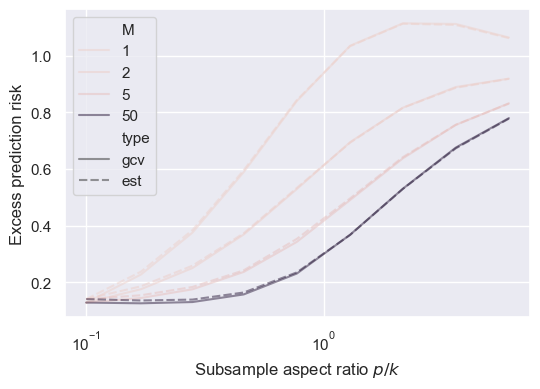

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(res[res['M'].isin([1,2,5,50])], x='psi', y='R', hue='M', style='type', alpha=0.5, errorbar=None, ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Subsample aspect ratio $p/k$')
ax.set_ylabel('Excess prediction risk')